# Brownian Dynamics

In [1]:
from math import pi, sqrt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import random as rnd

In [2]:
def initial_configuration(num_of_particles, box_length, mean_distance):
    xi = []
    yi = []
    zi = []
    
    xi.append(0.5 * (mean_distance - box_length))
    yi.append(0.5 * (mean_distance - box_length))
    zi.append(0.5 * (mean_distance - box_length))
    
    for i in range(1, num_of_particles):
        x = xi[i - 1] + mean_distance
        y = yi[i - 1]
        z = zi[i - 1]
        
        if x > 0.5 * box_length:
            x = xi[0]
            y = yi[i - 1] + mean_distance
            
            if y > 0.5 * box_length:
                x = xi[0]
                y = yi[0]
                z = zi[i - 1] + mean_distance
            
        xi.append(x)
        yi.append(y)
        zi.append(z)
        
    return xi, yi, zi

In [3]:
def hard_sphere(r, rx, ry, rz, lr, la, a2, epi):
    if r < (lr / la)**(1.0 / (lr - la)):
        potential_energy = (a2 / epi) * ((1.0 / r)**lr - (1.0 / r)**la) + 1.0 / epi
        f = lr * (1.0 / r)**(lr + 1.0) - la * (1.0 / r)**(la + 1.0)
        f *= a2 / epi
    else:
        potential_energy = 0.0
        f = 0.0
    fx = f * rx / r
    fy = f * ry / r
    fz = f * rz / r
    
    return potential_energy, fx, fy, fz

In [4]:
def force(x, y, z, box_length, cut_ratio, lr, la, a2, epi):
    num_of_particles = len(x)
    x_force = np.zeros(num_of_particles)
    y_force = np.zeros(num_of_particles)
    z_force = np.zeros(num_of_particles)
    energy = 0.0
    
    for i in range(num_of_particles):
        for j in range(i + 1, num_of_particles):
            xij = x[i] - x[j]
            yij = y[i] - y[j]
            zij = z[i] - z[j]
            xij -= box_length * round(xij / box_length)
            yij -= box_length * round(yij / box_length)
            zij -= box_length * round(zij / box_length)
            rij2 = xij**2 + yij**2 + zij**2
            rij = sqrt(rij2)
            
            if rij < cut_ratio:
                uij, fxij, fyij, fzij = hard_sphere(rij, xij, yij, zij, lr, la, a2, epi)
                energy += uij
                x_force[i] += fxij
                y_force[i] += fyij
                z_force[i] += fzij
                x_force[j] -= fxij
                y_force[j] -= fyij
                z_force[j] -= fzij
                
    return energy, x_force, y_force, z_force

In [5]:
def position(num_of_particles, box_length, x, y, z, fx, fy, fz, delta_t, pbc, my_seed):
    std_dev = 1.0
    mean = 0.0
    sigma = sqrt(2.0 * delta_t)
    rnd.seed(my_seed)
    
    for i in range(num_of_particles):
        dx = sigma * rnd.gauss(std_dev, mean)
        dy = sigma * rnd.gauss(std_dev, mean)
        dz = sigma * rnd.gauss(std_dev, mean)
        x[i] += dx + fx[i] * delta_t
        y[i] += dy + fy[i] * delta_t
        z[i] += dz + fz[i] * delta_t
        
        if pbc > 0.0:
            x[i] -= box_length * round(x[i] / box_length)
            y[i] -= box_length * round(y[i] / box_length)
            z[i] -= box_length * round(z[i] / box_length)
            
    return x, y, z

In [6]:
num_of_particles = 3**3 # Must be a cube
packing_fraction = 0.2
l_repulsive = 50.0
l_attractive = 49.0
epi = 1.4737
pbc = 1.0 # Periodic boundary condition
delta_t = 0.00001
therm_time = 250000
iseed = 1234567890
diameter = 6.0 * packing_fraction / pi
mean_distance = diameter**(-1.0 / 3.0)
box_length = (num_of_particles / diameter)**(1.0 / 3.0)
a2 = (l_repulsive / (l_repulsive - l_attractive)) * \
     (l_repulsive / l_attractive)**(l_attractive / (l_repulsive - l_attractive))
cut_ratio = 0.5 * box_length

In [7]:
x, y, z = initial_configuration(num_of_particles, box_length, mean_distance)

In [8]:
energy, x_force, y_force, z_force = force(x, y, z, box_length, cut_ratio, l_repulsive, l_attractive, a2, epi)

In [9]:
print("initial energy:", energy / num_of_particles)

initial energy: 0.0


Text(0.5,0,'Z')

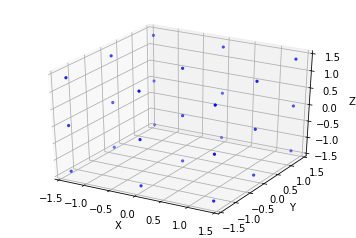

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c = 'b', marker = '.') 
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

In [32]:
for t in range(therm_time):
    x, y, z = position(num_of_particles, box_length, x, y, z, x_force, y_force, z_force, delta_t, pbc, iseed)
    energy, x_force, y_force, z_force = force(x, y, z, box_length, cut_ratio, l_repulsive, l_attractive, a2, epi)
    epotn = energy / num_of_particles
    if t%10000 == 0:
        print(t, epotn, 'Thermalization')

0 0.0 Thermalization
10000 0.0 Thermalization
20000 0.0 Thermalization
30000 0.0 Thermalization
40000 0.0 Thermalization
50000 0.0 Thermalization
60000 0.0 Thermalization
70000 0.0 Thermalization
80000 0.0 Thermalization
90000 0.0 Thermalization
100000 0.0 Thermalization
110000 0.0 Thermalization


KeyboardInterrupt: 

In [ ]:
open(51,file='energy.dat',status='unknown')
      do istep=1,nct
         call position(x,y,z,fx,fy,fz,pbc)
         call force(x,y,z,fx,fy,fz,enerpot)
         epotn=enerpot/dfloat(np)
	     if (mod(istep,10000) .eq. 0) print*,istep,epotn,'Thermalization'
	     if (mod(istep,100) .eq. 0) write(51,400)dfloat(istep),enerpot/np
      enddo

	  close(51)